In [1]:
import os
import tables
# Libraries for numpy arrays and data tables
import numpy as np
import pandas as pd

# Import abf files
import pyabf

# Find Peaks and audio functions
import scipy
from scipy import signal  # Filtering
from scipy.signal import find_peaks  # Find Peaks function
from scipy.io.wavfile import write  # Audio from NumPy array

# Plots and animations
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import animation

# Merge video and audio files
from moviepy.editor import VideoFileClip, AudioFileClip


#%matplotlib widget
plt.close('all')

In [3]:
# Experiment ID
experiment_id = 'Juxta_Som_Human_retina'  # E.g. 20230809_neuron01_a
# In case this was an ABF file
#data = f'/content/{experiment_id}.abf'
#abf = pyabf.ABF(data)

fn2='./data_example/Chevalier_data_human_retina_example.hdf5'

h2=tables.open_file(fn2,'r')
# Sampling rate
sampling_rate = h2.root.parameters._v_attrs['Sample Rate']
time = np.linspace(0,len(h2.root.sync.read()[:,1])/sampling_rate,num=len(h2.root.sync.read()[:,1]))

# Display what the save_plot_auto_detect_cell function would do with the given fn2
folder_path_sample = os.path.dirname(fn2)
hdf5_file_name_sample = os.path.basename(fn2)
cell_number_sample = hdf5_file_name_sample.split('_')[1]
numbers_sample = hdf5_file_name_sample.split('_')[-1].replace('.hdf5', '')
png_file_name_sample = f"{cell_number_sample}_{numbers_sample}_plot.png"
full_png_path_sample = os.path.join(folder_path_sample, png_file_name_sample)


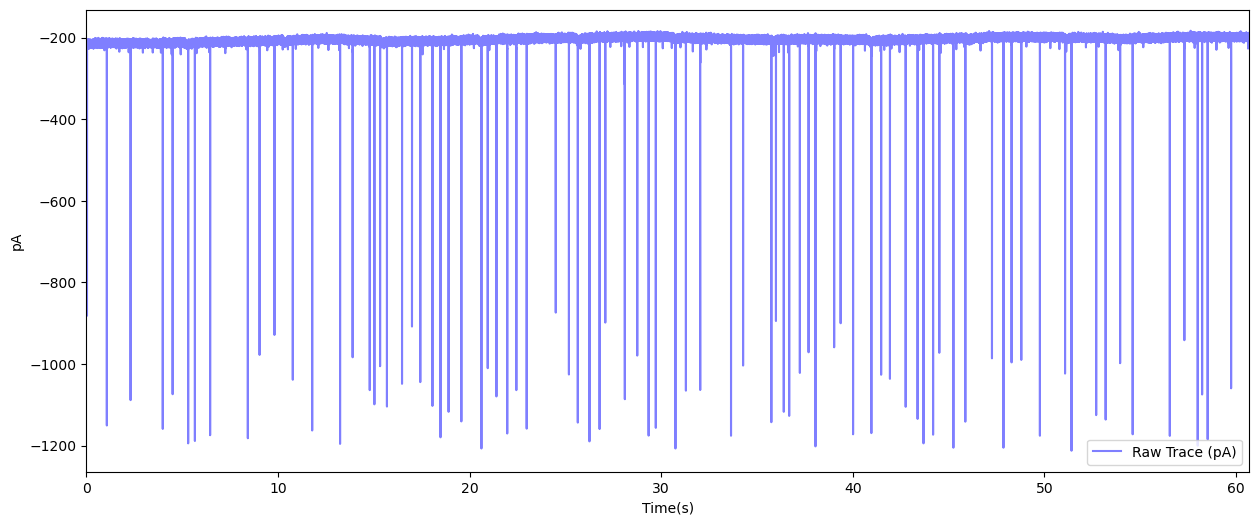

In [4]:
# If this was abf following steps could be used
# Sampling rate for an ABF file
# fs = int(abf.dataPointsPerMs * 1000)

# Quick plot to see the trace/s
# plt.figure(figsize=(6,3))

#  To select channel/sweep: abf.setSweep(sweepNumber=0, channel=0)
# for sweepNumber in abf.sweepList:  # Only 1 sweep in the example
#     abf.setSweep(sweepNumber)
#     y_variable = abf.sweepY
#     time = abf.sweepX

#     # Plot
#     plt.plot(time, y_variable)
#     plt.ylabel(abf.sweepLabelY)
#     plt.xlabel(abf.sweepLabelX)

# # Print the sampling rate
# print("Sampling rate:", fs)

# # Show the plot
# plt.tight_layout()  # Adjust the padding around the plot
# plt.show()


# For HDF5, we can do:
# Plot raw trace and laser stimulus overlayed

# Calculate trace
trace = h2.root.sync.read()[:,1] / h2.root.parameters._v_attrs['Current Gain'] * 1000

# Plotting
# Create a plot for the trace and the laser stimulus
plt.figure(figsize=(15, 6))

# Plot the raw trace
plt.plot(time, trace, label='Raw Trace (pA)', color='b',alpha=0.5)

# Labels and legends
plt.ylabel('pA')
plt.xlabel('Time(s)')
plt.legend()

# x-axis tight
plt.xlim(min(time), max(time))

# Fig size
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15

# Save if needed
#png_file_name_sample = f"{cell_number_sample}_{numbers_sample}_raw_WL_over.png"
#full_png_path_sample = os.path.join(folder_path_sample, png_file_name_sample)
#plt.savefig(full_png_path_sample, dpi=600)

# Show the plot
plt.show()


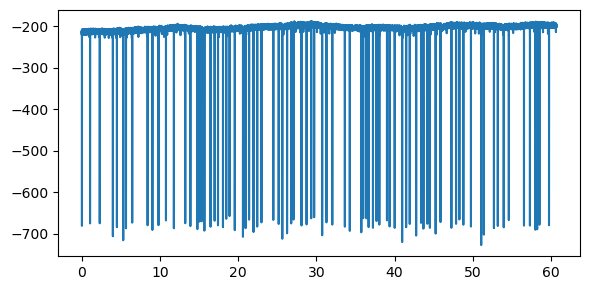

In [ ]:
# Lowpass Bessel filter

fs = sampling_rate;
b_lowpass, a_lowpass = signal.bessel(4,     # Order of the filter
                                     2000,  # Cutoff frequency
                                     'low', # Type of filter
                                     analog=False,  # Analog or digital filter
                                     norm='phase',  # Critical frequency normalization
                                     fs=fs)  # fs: sampling frequency

signal_filtered = signal.filtfilt(b_lowpass, a_lowpass, trace)

# Adjust the baseline if needed
# signal_filtered = signal_filtered - np.median(signal_filtered)

# Simple plot
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(time, signal_filtered)
#plt.xlim(4,6)
# Show the plot
plt.tight_layout()
plt.show()

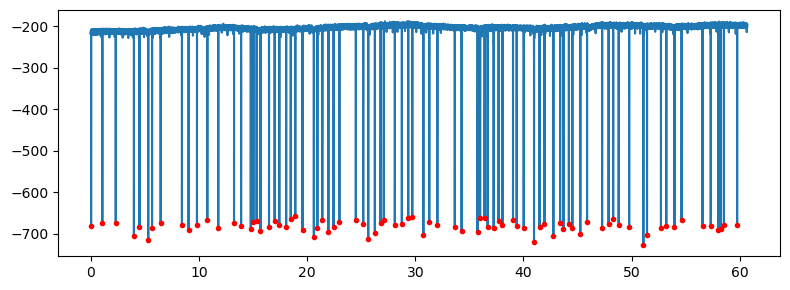

In [ ]:
# Assign the variables here to simplify the code

# Threshold for peak detection (absolute value)
peaks_theshold = 300

# Find peaks function
peaks, peaks_dict = find_peaks(-signal_filtered,  # Note: change the polarity of signal for negative peaks
                               height=peaks_theshold)

# Plot the detected spikes in the trace
fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(time, signal_filtered)

# Red dot for each detected spike
ax.plot(peaks/fs, signal_filtered[peaks], "r.")
#ax.set_xlabel(abf.sweepLabelX)
#ax.set_ylabel(abf.sweepLabelY)
#plt.xlim(4,5)
fig.tight_layout()  # Adjust layout
plt.show()

Animation (number of frames): 1516


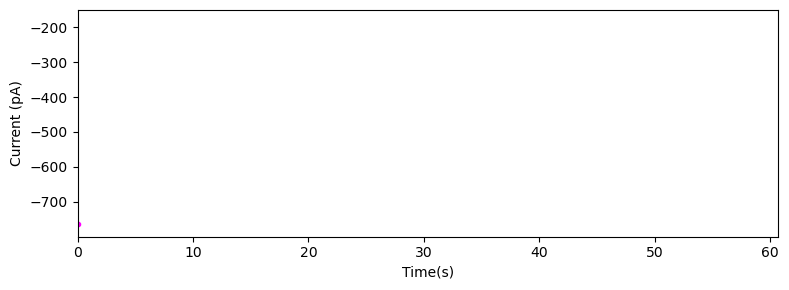

In [ ]:
# Initialize the plot
fig, ax = plt.subplots(figsize=(8, 3))
y_variable = signal_filtered;

# Define plot parameters
line, = ax.plot([], [], lw=1, color='tab:blue')  # Initialize a line plot
events, = ax.plot([], [], 'o', color='magenta', markersize=3)  # Optional: detected events

# Axis options
ax.set_xlabel("Time(s)")  # Set x-axis label
ax.set_ylabel("Current (pA)")  # You can also use 'abf.sweepLabelY'
ax.set_xlim(np.min(time), np.max(time))  # Set x-axis limits

# Set y-axis limits with some upper and bottom blank space
ax.set_ylim(np.min(y_variable) + (0.1 * np.min(y_variable)),
            np.max(y_variable) - (0.2 * np.max(y_variable)))

# Animation function
interval = 400  # Adapt to your data fs

def animate(frame):
    end_frame = (frame + 1) * interval  # End frame for each update in the animation
    line.set_data(time[:end_frame], y_variable[:end_frame])  # Update line plot data

    # Comment out the 'events' lines if you do not want to show detected peaks
    events_time = time[peaks[peaks < end_frame]]  # Extract event times
    events_signal = y_variable[peaks[peaks < end_frame]]
    events.set_data([events_time], [np.min(y_variable[peaks]) * 1.05])  # Event dots at fixed height
    # events.set_data(events_time, events_signal * 1.1)  # Event dots at variable heights

    return line, events

# Create the animation
frames = len(time) // interval

anim = animation.FuncAnimation(fig, animate, frames=frames,
                               interval=5, blit=True, repeat=False)

print("Animation (number of frames):", frames)

fig.tight_layout()  # Adjust layout
plt.show()  # Display the animation

In [ ]:
%%time

# Animation parameters
duration_s = 10  # Select the length of the video here

anim_fps = frames/duration_s

extra_args = [
    '-vcodec', 'libx264',  # Video codec
    '-s', '2400x900',]  # Set the output resolution, same ratio as figure size

# Create the video with FFMpegWriter
writer = animation.FFMpegWriter(fps=anim_fps, bitrate=3000,
                                codec="h264",  extra_args=extra_args)

# Save the animation
anim.save(f'{experiment_id}_video.mp4', writer=writer)

# Print the fps and duration of the final video
print('Video_duration (s):', frames/anim_fps)
print('Video_fps:', anim_fps)

Video_duration (s): 10.0
Video_fps: 151.6
CPU times: user 1min 8s, sys: 1.05 s, total: 1min 9s
Wall time: 1min 10s


In [ ]:
# Create and save it as a GIF
writergif = animation.PillowWriter(fps=anim_fps, bitrate=2000)

anim.save(f'{experiment_id}_video.gif', writer=writergif)

In [ ]:
# Create audio to go with the animation
# Audio parameters
amplitude = np.iinfo(np.int16).max  # Get the max value of the audio type (e.g. 16 bits)
audio_fs = int(len(y_variable)/duration_s)
gain = 1  # Set to 1 if not needed

# Normalize the ephys data in the range [-1, 1]
normalized_data = y_variable / np.max(np.abs(y_variable))

# Scale data option 1: to the audio range and, optionally, multiply by some gain
# scaled_data = np.int16(normalized_data * amplitude * gain)

# Scale data option 2: clipping the data to get less background noise
scaled_data = np.int16(np.clip(normalized_data, -1, -0.06) * amplitude * gain)

# Save the NumPy array as a WAV file
write(f'{experiment_id}_audio.wav', rate=audio_fs, data=scaled_data)


In [5]:
# Merge audio and video

# Load the video and audio files
video_clip = VideoFileClip(f'{experiment_id}_video.mp4')
audio_clip = AudioFileClip(f'{experiment_id}_audio.wav')

# Set the audio of the video clip
video_clip = video_clip.set_audio(audio_clip)

# Save the video
save_path = f'{experiment_id}_merge.mp4'

video_clip.write_videofile(save_path,
                           codec='libx264', bitrate='3000k',
                           audio_codec='aac', temp_audiofile='temp_audio.m4a',
                           remove_temp=True)

# Close the clips
video_clip.close()
audio_clip.close()

Moviepy - Building video Juxta_Som_Human_retina_merge.mp4.
MoviePy - Writing audio in temp_audio.m4a


MoviePy - Done.
Moviepy - Writing video Juxta_Som_Human_retina_merge.mp4



Moviepy - Done !
Moviepy - video ready Juxta_Som_Human_retina_merge.mp4
